In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ----------------------------------------------------
# 1. Load dataset (using your corrected file path)
# ----------------------------------------------------
df = pd.read_csv("C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/fruits_dataset.csv")

# ----------------------------------------------------
# 2. Basic cleaning
# ----------------------------------------------------

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Fix incorrect acidity_pH for Date (282 → ~3.5)
df.loc[df['fruit_name'] == 'Date', 'acidity_pH'] = 3.5

# Ensure numeric columns are numeric
numeric_cols = [
    'sugar_g', 'calories', 'acidity_pH', 'avg_weight_g',
    'water_percent', 'fiber_g_per_100g', 'shelf_life_days'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop duplicates if any
df = df.drop_duplicates()

# ----------------------------------------------------
# 3. Feature Engineering
# ----------------------------------------------------

# 3.1 Calorie density (calories per gram)
df['calorie_density'] = df['calories'] / df['avg_weight_g']

# 3.2 Sugar density (sugar per gram)
df['sugar_density'] = df['sugar_g'] / df['avg_weight_g']

# 3.3 Water-to-fiber ratio
df['water_fiber_ratio'] = df['water_percent'] / df['fiber_g_per_100g']

# 3.4 Sweetness index (sugar divided by acidity)
df['sweetness_index'] = df['sugar_g'] / df['acidity_pH']

# 3.5 Shelf-life category
def shelf_life_category(days):
    if days <= 7:
        return "Short"
    elif days <= 30:
        return "Medium"
    else:
        return "Long"

df['shelf_life_category'] = df['shelf_life_days'].apply(shelf_life_category)

# 3.6 Weight category
def weight_category(w):
    if w < 50:
        return "Small"
    elif w <= 300:
        return "Medium"
    else:
        return "Large"

df['weight_category'] = df['avg_weight_g'].apply(weight_category)

# 3.7 Tropical flag
tropical_fruits = [
    'Pineapple', 'Mango', 'Papaya', 'Coconut', 'Guava', 'Passionfruit',
    'Lychee', 'Dragonfruit', 'Jackfruit', 'Starfruit'
]
df['is_tropical'] = df['fruit_name'].isin(tropical_fruits).astype(int)

# 3.8 Vitamin encoding (ordinal scale)
vitamin_scale = {'A': 5, 'B6': 4, 'C': 3, 'E': 2, 'K': 1}
df['vitamin_score'] = df['top_vitamin'].map(vitamin_scale)

# 3.9 Mineral encoding
mineral_scale = {'Potassium': 5, 'Manganese': 4, 'Calcium': 3, 'Iron': 2}
df['mineral_score'] = df['top_mineral'].map(mineral_scale)

# 3.10 Nutrient density score (weighted composite)
df['nutrient_density'] = (
    0.4 * df['fiber_g_per_100g'] +
    0.3 * (df['water_percent'] / 100) +
    0.3 * ((df['vitamin_score'] + df['mineral_score']) / 10)
)

# ----------------------------------------------------
# 4. One-hot encoding (optional)
# ----------------------------------------------------
df = pd.get_dummies(df, columns=['season', 'taste_profile'], prefix=['season', 'taste'])

# ----------------------------------------------------
# 5. Final cleaned dataframe
# ----------------------------------------------------
print(df.head())


   fruit_name  sugar_g  calories  acidity_pH top_vitamin top_mineral  \
0      Banana     12.0        89         5.0          B6   Potassium   
1  Strawberry      4.9        32         3.0           C   Manganese   
2       Apple     10.0        52         3.3           C   Potassium   
3        Pear      9.8        57         3.5           C   Potassium   
4      Cherry     12.0        63         4.0           C   Potassium   

   avg_weight_g  water_percent  fiber_g_per_100g  shelf_life_days  ...  \
0           118             74               2.6                7  ...   
1            12             91               2.0                5  ...   
2           182             86               2.4               30  ...   
3           178             84               3.1               30  ...   
4             8             82               2.1                7  ...   

   season_All  season_Fall  season_Spring  season_Summer season_Winter  \
0        True        False          False       

In [3]:
top_nutrient_dense = (
    df[['fruit_name', 'nutrient_density']]
    .sort_values('nutrient_density', ascending=False)
    .head(10)
)
print(top_nutrient_dense)


     fruit_name  nutrient_density
22      Coconut             3.951
35         Date             3.443
23      Avocado             3.079
11    Raspberry             3.068
24        Guava             2.643
26       Lychee             2.606
33    Cranberry             2.101
21  Pomegranate             2.074
34    Persimmon             1.983
29    Nectarine             1.764


C:\Users\eguen\AppData\Local\Temp\ipykernel_15268\666961492.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


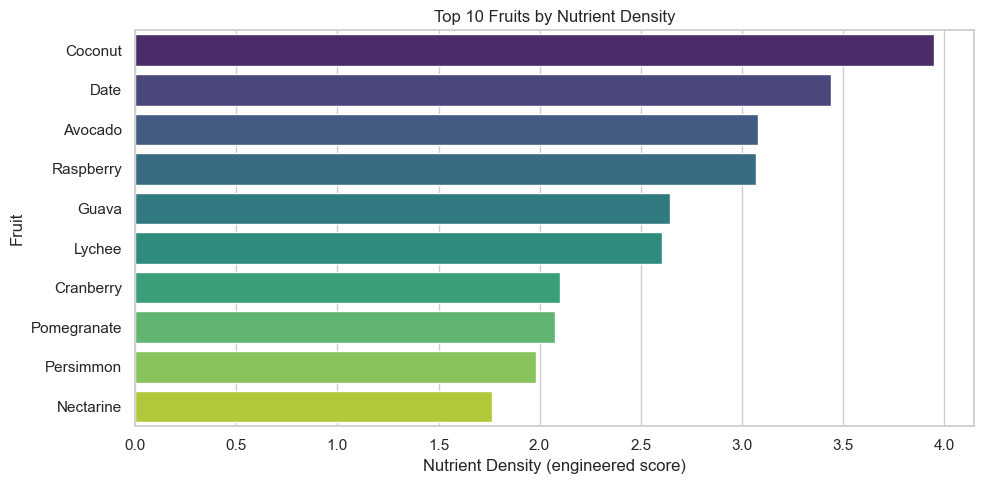

In [4]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_nutrient_dense,
    x='nutrient_density',
    y='fruit_name',
    palette='viridis'
)
plt.title("Top 10 Fruits by Nutrient Density")
plt.xlabel("Nutrient Density (engineered score)")
plt.ylabel("Fruit")
plt.tight_layout()
plt.show()


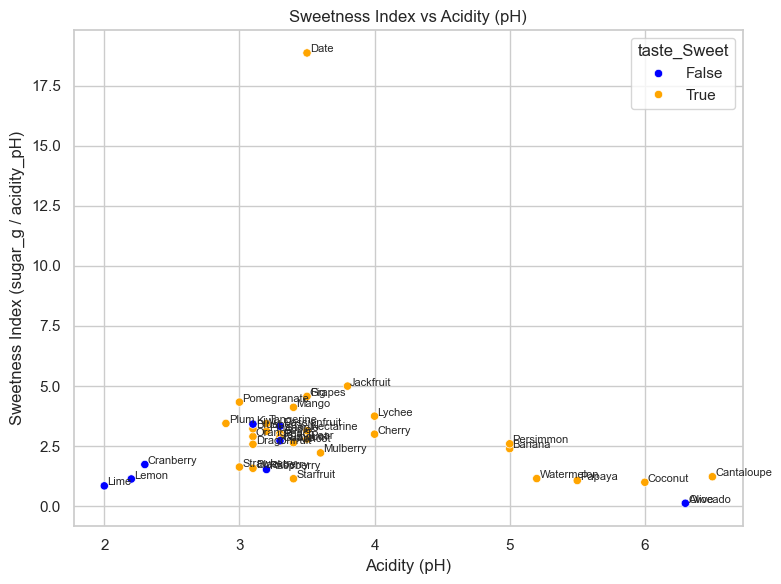

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='acidity_pH',
    y='sweetness_index',
    hue='taste_Sweet',  # True/False from one-hot
    palette={True: 'orange', False: 'blue'}
)
for _, row in df.iterrows():
    plt.text(row['acidity_pH'] + 0.02,
             row['sweetness_index'] + 0.02,
             row['fruit_name'],
             fontsize=8)
plt.title("Sweetness Index vs Acidity (pH)")
plt.xlabel("Acidity (pH)")
plt.ylabel("Sweetness Index (sugar_g / acidity_pH)")
plt.tight_layout()
plt.show()


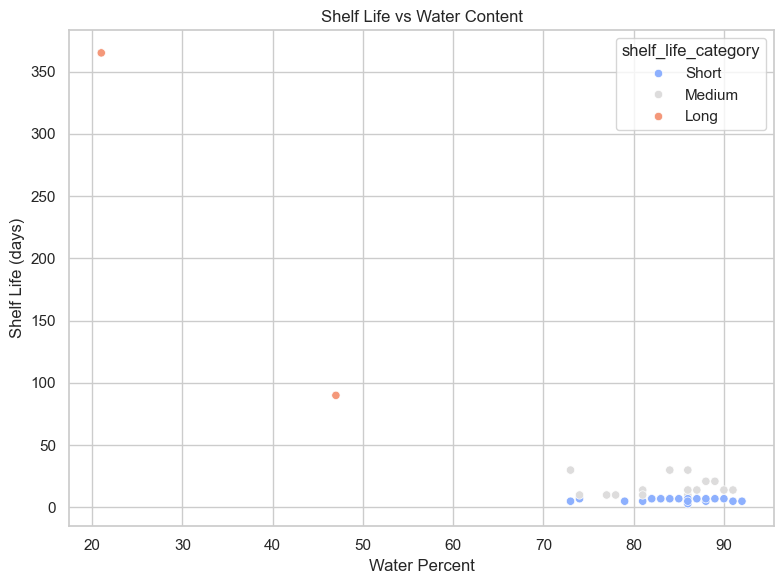

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='water_percent',
    y='shelf_life_days',
    hue='shelf_life_category',
    palette='coolwarm'
)
plt.title("Shelf Life vs Water Content")
plt.xlabel("Water Percent")
plt.ylabel("Shelf Life (days)")
plt.tight_layout()
plt.show()


In [7]:
corr = df[['water_percent', 'shelf_life_days']].corr()
print(corr)


                 water_percent  shelf_life_days
water_percent         1.000000        -0.867126
shelf_life_days      -0.867126         1.000000


In [8]:
trop_group = df.groupby('is_tropical').agg({
    'sugar_g': 'mean',
    'calories': 'mean',
    'nutrient_density': 'mean'
}).rename(index={0: 'Non-tropical', 1: 'Tropical'})

print(trop_group)


                sugar_g   calories  nutrient_density
is_tropical                                         
Non-tropical  10.458621  66.551724            1.5890
Tropical      10.170000  91.400000            1.7706


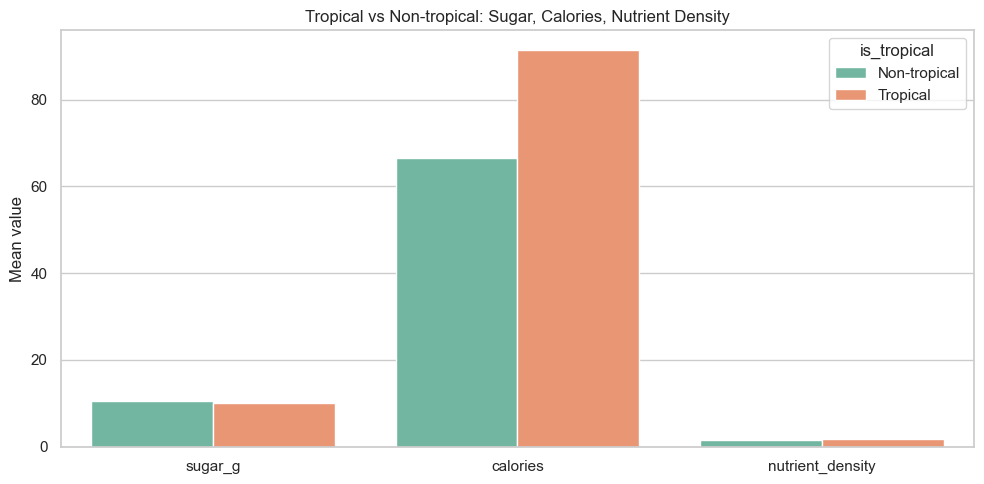

In [9]:
trop_melted = trop_group.reset_index().melt(
    id_vars='is_tropical',
    value_vars=['sugar_g', 'calories', 'nutrient_density'],
    var_name='metric',
    value_name='value'
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=trop_melted,
    x='metric',
    y='value',
    hue='is_tropical',
    palette='Set2'
)
plt.title("Tropical vs Non-tropical: Sugar, Calories, Nutrient Density")
plt.xlabel("")
plt.ylabel("Mean value")
plt.tight_layout()
plt.show()


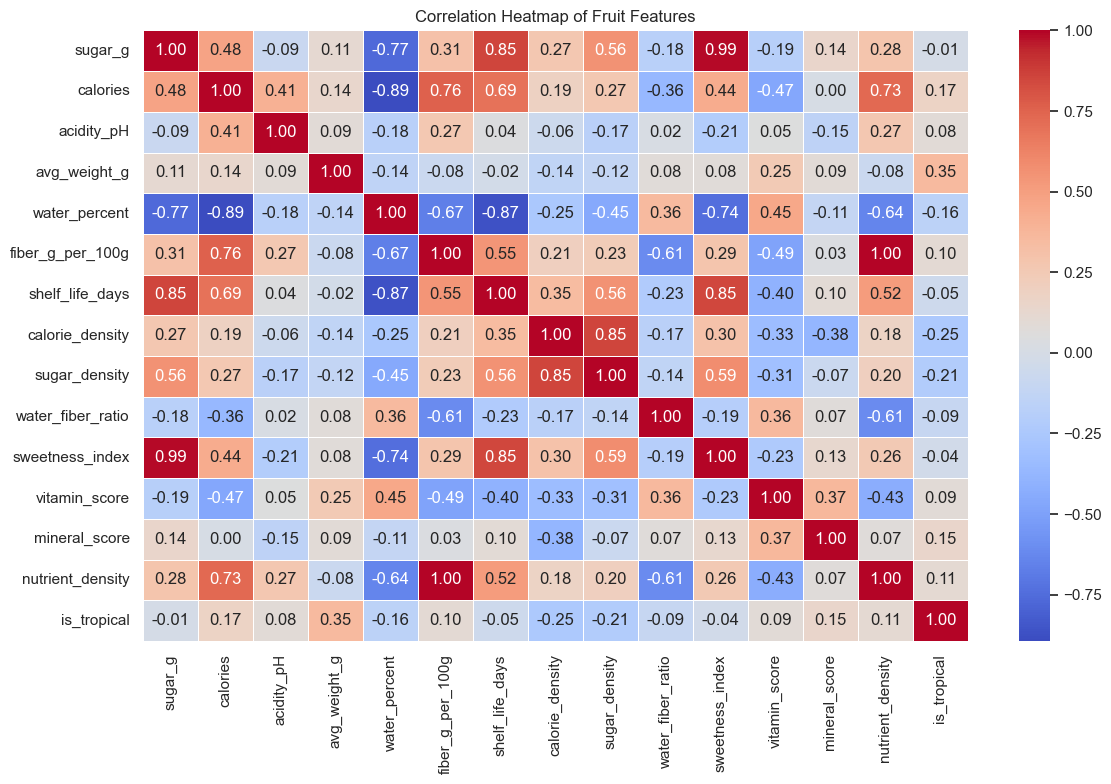

In [13]:
plt.figure(figsize=(12, 8))
num_cols = [
    'sugar_g', 'calories', 'acidity_pH', 'avg_weight_g',
    'water_percent', 'fiber_g_per_100g', 'shelf_life_days',
    'calorie_density', 'sugar_density', 'water_fiber_ratio',
    'sweetness_index', 'vitamin_score', 'mineral_score',
    'nutrient_density', 'is_tropical'
]
corr = df[num_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Fruit Features")
plt.tight_layout()
plt.show()


In [14]:
# Rebuild taste_profile from one-hot columns
taste_cols = [col for col in df.columns if col.startswith("taste_")]

df['taste_profile'] = df[taste_cols].idxmax(axis=1).str.replace("taste_", "")


In [17]:
taste_group = df.groupby('taste_profile').agg({
    'sugar_g': 'mean',
    'acidity_pH': 'mean',
    'calorie_density': 'mean',
    'nutrient_density': 'mean',
    'shelf_life_days': 'mean'
}).round(2)

print(taste_group)


               sugar_g  acidity_pH  calorie_density  nutrient_density  \
taste_profile                                                           
Bitter            0.80        6.30            38.33              1.58   
Creamy            0.70        6.30             0.80              3.08   
Sour              4.40        2.50             1.54              1.19   
Sweet            11.99        3.80             5.48              1.58   
Tart              7.62        2.98            16.30              2.02   

               shelf_life_days  
taste_profile                   
Bitter                   14.00  
Creamy                   30.00  
Sour                     18.67  
Sweet                    24.03  
Tart                      5.50  


In [19]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [21]:
import sys
print(sys.executable)


c:\Users\eguen\AppData\Local\Programs\Python\Python311\python.exe


In [22]:
!c:/Users/eguen/AppData/Local/Programs/Python/Python311/python.exe -m pip install scikit-learn


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 8.5 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.1 MB 8.8 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 9.7 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 10.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.7 MB ? eta -:--:--
   - -------------------------------------- 1.8/38.7 MB 9.2 MB/s eta 0:00:05
   ---- ----------------------------------- 4.2/38.7 MB 10.1 MB/s eta 0:00:04
   ------ --------------------------------- 6.6/38.7 MB 10.1 MB/s eta 0:00:04
   --------- ------------------------------ 9.4/38.7 MB 10.9 MB/s eta 0:00:03
   ------------ --------------------------- 11.8/38.7 MB 10.9 MB/s eta 0:00:03
   -------------- --


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
import pandas as pd

df = pd.read_csv("C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/fruits_dataset.csv")


In [4]:
import numpy as np

# Fix column names
df.columns = df.columns.str.strip()

# Fix incorrect acidity for Date
df.loc[df['fruit_name'] == 'Date', 'acidity_pH'] = 3.5

# Ensure numeric columns
numeric_cols = [
    'sugar_g', 'calories', 'acidity_pH', 'avg_weight_g',
    'water_percent', 'fiber_g_per_100g', 'shelf_life_days'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Feature engineering
df['calorie_density'] = df['calories'] / df['avg_weight_g']
df['sugar_density'] = df['sugar_g'] / df['avg_weight_g']
df['water_fiber_ratio'] = df['water_percent'] / df['fiber_g_per_100g']
df['sweetness_index'] = df['sugar_g'] / df['acidity_pH']

vitamin_scale = {'A': 5, 'B6': 4, 'C': 3, 'E': 2, 'K': 1}
mineral_scale = {'Potassium': 5, 'Manganese': 4, 'Calcium': 3, 'Iron': 2}

df['vitamin_score'] = df['top_vitamin'].map(vitamin_scale)
df['mineral_score'] = df['top_mineral'].map(mineral_scale)

df['nutrient_density'] = (
    0.4 * df['fiber_g_per_100g'] +
    0.3 * (df['water_percent'] / 100) +
    0.3 * ((df['vitamin_score'] + df['mineral_score']) / 10)
)

# One-hot encoding
df = pd.get_dummies(df, columns=['season', 'taste_profile'], prefix=['season', 'taste'])


In [5]:
df.head()


,fruit_name,sugar_g,calories,acidity_pH,top_vitamin,top_mineral,avg_weight_g,water_percent,fiber_g_per_100g,shelf_life_days,...,season_All,season_Fall,season_Spring,season_Summer,season_Winter,taste_Bitter,taste_Creamy,taste_Sour,taste_Sweet,taste_Tart
0,Banana,12.0,89,5.0,B6,Potassium,118,74,2.6,7,...,True,False,False,False,False,False,False,False,True,False
1,Strawberry,4.9,32,3.0,C,Manganese,12,91,2.0,5,...,False,False,True,False,False,False,False,False,True,False
2,Apple,10.0,52,3.3,C,Potassium,182,86,2.4,30,...,False,True,False,False,False,False,False,False,True,False
3,Pear,9.8,57,3.5,C,Potassium,178,84,3.1,30,...,False,True,False,False,False,False,False,False,True,False
4,Cherry,12.0,63,4.0,C,Potassium,8,82,2.1,7,...,False,False,False,True,False,False,False,False,True,False


In [6]:
y = df['shelf_life_days']


In [8]:
tropical_fruits = [
    'Pineapple','Mango','Papaya','Coconut','Guava','Passionfruit',
    'Lychee','Dragonfruit','Jackfruit','Starfruit','Banana'
]

df['is_tropical'] = df['fruit_name'].isin(tropical_fruits).astype(int)


In [9]:
df.columns


Index(['fruit_name', 'sugar_g', 'calories', 'acidity_pH', 'top_vitamin',
       'top_mineral', 'avg_weight_g', 'water_percent', 'fiber_g_per_100g',
       'shelf_life_days', 'calorie_density', 'sugar_density',
       'water_fiber_ratio', 'sweetness_index', 'vitamin_score',
       'mineral_score', 'nutrient_density', 'season_All', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'taste_Bitter',
       'taste_Creamy', 'taste_Sour', 'taste_Sweet', 'taste_Tart',
       'is_tropical'],
      dtype='object')

In [10]:
feature_cols = [
    'sugar_g', 'calories', 'acidity_pH', 'avg_weight_g',
    'water_percent', 'fiber_g_per_100g',
    'calorie_density', 'sugar_density', 'water_fiber_ratio',
    'sweetness_index', 'vitamin_score', 'mineral_score',
    'nutrient_density', 'is_tropical'
]

season_cols = [c for c in df.columns if c.startswith('season_')]
taste_cols  = [c for c in df.columns if c.startswith('taste_')]

feature_cols = feature_cols + season_cols + taste_cols

X = df[feature_cols]


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f} days")
print(f"RMSE: {rmse:.2f} days")
print(f"R²:   {r2:.3f}")


MAE:  4.98 days
RMSE: 7.84 days
R²:   -6.586


In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(mae, rmse, r2)


72.46494462293987 107.60602666361738 -1426.8605902836084


In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 2.349393332208228
RMSE: 3.189448097338921
R²: -0.25442209364086166


In [3]:
import pandas as pd

df = pd.read_csv("C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/fruits_dataset.csv")


In [4]:
df.head()


,fruit_name,sugar_g,calories,acidity_pH,season,top_vitamin,top_mineral,avg_weight_g,water_percent,fiber_g_per_100g,taste_profile,shelf_life_days
0,Banana,12.0,89,5.0,All,B6,Potassium,118,74,2.6,Sweet,7
1,Strawberry,4.9,32,3.0,Spring,C,Manganese,12,91,2.0,Sweet,5
2,Apple,10.0,52,3.3,Fall,C,Potassium,182,86,2.4,Sweet,30
3,Pear,9.8,57,3.5,Fall,C,Potassium,178,84,3.1,Sweet,30
4,Cherry,12.0,63,4.0,Summer,C,Potassium,8,82,2.1,Sweet,7


In [5]:
df.head(30).to_csv("C:/Users/eguen/Desktop/fruitfusion_first_30_rows.csv", index=False)


OSError: Cannot save file into a non-existent directory: 'C:\Users\eguen\Desktop'